In [ ]:
# Course work Ustymenko Danylo May 2023
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
import tensorflow as tf
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.interpolate import PchipInterpolator
from bisect import bisect
from random import shuffle, randint

In [ ]:
def read_h5 (path):
  return np.array(h5py.File(path, 'r')["img\\"])

In [ ]:
def generate_name (n):
  res = f"{n}"
  for _ in range(4 - len(res)):
    res = "0" + res
  return os.path.join(KAUST_PATH, "KAUST_" + res + ".mat")

In [ ]:
def read_mat(path):
  return spio.loadmat(path)["cube"]


In [ ]:
def mat_to_h5 (path, n):
  arr = read_mat(path)
  new_name = generate_name(n)
  print(new_name)
  os.remove(path)
  with h5py.File(new_name, "w") as f:
    f.create_dataset("img\\", data = arr)

In [ ]:
def h5_to_mat(path, n):
  with h5py.File(path, 'r') as f:
    hyper = np.array(f["img\\"])
    rgb = np.array(f["rgb"])
    new_name = generate_name(n)
    os.remove(path)
    spio.savemat(new_name, {"hyper": hyper, "rgb": rgb})

In [ ]:
KAUST_PATH = "/content/gdrive/MyDrive/KAUST"
ARAD_PATH = "/content/gdrive/MyDrive/ARAD"
VAL_PATH = "/content/gdrive/MyDrive/val"
VAL_ARAD_PATH = "/content/gdrive/MyDrive/val_ARAD"
X_SHAPE = 480
Y_SHAPE = 512
Z_SHAPE = 31
BATCH_SIZE = 8

In [ ]:
def process_h5 (path, n): #change shape and dimensions
  shape_goal = (X_SHAPE, Y_SHAPE, Z_SHAPE)
  res = read_h5(path)
  if res.shape != shape_goal:
    os.remove(path)
    res = res[:-3]
    res = np.moveaxis(res, 0, -1)
    res = np.array(tf.image.random_crop(value=res, size=shape_goal))
    new_name = generate_name(n)
    print(new_name)
    with h5py.File(new_name, "w") as f:
      f.create_dataset("img\\", data = res)

In [ ]:
def HSI2RGB(HSI,d = 65,threshold = 0.002, wY = list(range(400, 710, 10))):
# Source:
#  M. Magnusson, J. Sigurdsson, S. E. Armansson, M. O. Ulfarsson, 
#  H. Deborah and J. R. Sveinsson, 
#  "Creating RGB Images from Hyperspectral Images Using a Color Matching Function", 
#  IEEE International Geoscience and Remote Sensing Symposium, Virtual Symposium, 2020

# Paper is available at
# https://www.researchgate.net/profile/Jakob_Sigurdsson


    
    # Load reference illuminant
  ydim, xdim, zdim = HSI.shape
  HSI = np.reshape(HSI, [-1, zdim])/HSI.max()
  D = spio.loadmat('/content/gdrive/MyDrive/D_illuminants.mat')
  w = D['wxyz'][:,0]
  x = D['wxyz'][:,1]
  y = D['wxyz'][:,2]
  z = D['wxyz'][:,3]
  D = D['D']
  
  i = {50:2,
        55:3,
        65:1,
        75:4}
  wI = D[:,0];
  I = D[:,i[d]];
      
  # Interpolate to image wavelengths
  I = PchipInterpolator(wI,I,extrapolate=True)(wY) # interp1(wI,I,wY,'pchip','extrap')';
  x = PchipInterpolator(w,x,extrapolate=True)(wY) # interp1(w,x,wY,'pchip','extrap')';
  y = PchipInterpolator(w,y,extrapolate=True)(wY) # interp1(w,y,wY,'pchip','extrap')';
  z = PchipInterpolator(w,z,extrapolate=True)(wY) # interp1(w,z,wY,'pchip','extrap')';

  # Truncate at 780nm
  i=bisect(wY, 780)
  HSI=HSI[:,0:i]/HSI.max()
  wY=wY[:i]
  I=I[:i]
  x=x[:i]
  y=y[:i]
  z=z[:i]
  
  # Compute k
  k = 1/np.trapz(y * I, wY)
  
  # Compute X,Y & Z for image
  X = k * np.trapz(HSI @ np.diag(I * x), wY, axis=1)
  Z = k * np.trapz(HSI @ np.diag(I * z), wY, axis=1)
  Y = k * np.trapz(HSI @ np.diag(I * y), wY, axis=1)
  
  XYZ = np.array([X, Y, Z])
  
  # Convert to RGB
  M = np.array([[3.2404542, -1.5371385, -0.4985314],
                [-0.9692660, 1.8760108, 0.0415560],
                [0.0556434, -0.2040259, 1.0572252]]);
  print(M.shape)
  print(XYZ.shape)
  sRGB=M@XYZ;
  
  # Gamma correction
  gamma_map = sRGB >  0.0031308;
  sRGB[gamma_map] = 1.055 * np.power(sRGB[gamma_map], (1. / 2.4)) - 0.055;
  sRGB[np.invert(gamma_map)] = 12.92 * sRGB[np.invert(gamma_map)];
  # Note: RL, GL or BL values less than 0 or greater than 1 are clipped to 0 and 1.
  sRGB[sRGB > 1] = 1;
  sRGB[sRGB < 0] = 0;
  
  if threshold:
      for idx in range(3):
          y = sRGB[idx,:];
          a,b = np.histogram(y,100)
          b = b[:-1] + np.diff(b)/2
          a=np.cumsum(a)/np.sum(a)
          th = b[0]
          i = a<threshold;
          if i.any():
              th=b[i][-1];
          y=y-th
          y[y<0] = 0

          a,b=np.histogram(y,100)
          b = b[:-1] + np.diff(b)/2
          a=np.cumsum(a)/np.sum(a);
          i = a > 1-threshold
          th=b[i][0]
          y[y>th]=th
          y=y/th
          sRGB[idx,:]=y
      
  R = np.reshape(sRGB[0,:],[ydim,xdim]);
  G = np.reshape(sRGB[1,:],[ydim,xdim]);
  B = np.reshape(sRGB[2,:],[ydim,xdim]);
  return np.transpose(np.array([R,G,B]),[1,2,0])

In [ ]:
def add_rgb_to_h5 (file_name):
  with h5py.File(file_name, "r+") as f:
    if "rgb" not in f:
      dt = HSI2RGB(np.array(f["img\\"]))
      f.create_dataset("rgb", data = dt)

In [ ]:
def update_h5 (dir):
  with os.scandir(dir) as iter:
    for f in iter:
      add_rgb_to_h5(f.path)
      print(f.path)

In [ ]:
def cut_x(file_name):
  hyper = spio.loadmat(file_name)["hyper"]
  rgb = spio.loadmat(file_name)["rgb"]
  if rgb.shape[0] != 480:
    os.remove(file_name)
    file_name = file_name.replace("_0", "_1")
    print(file_name)
    hyper = hyper[1:-1]
    rgb = rgb[1:-1]
    spio.savemat(file_name, {"hyper": hyper, "rgb": rgb})

In [ ]:
class DataGen(tf.keras.utils.Sequence):

  def __init__(self, dir_path,
                batch_size,
                input_size=(X_SHAPE, Y_SHAPE, 3)):

    self.dir_path = dir_path
    self.file_names = [os.path.join(dir_path, i) for i in os.listdir(self.dir_path)]
    # self.file_names = [os.path.join(dir_path[0], i) for i in os.listdir(self.dir_path[0])] + [os.path.join(dir_path[1], i) for i in os.listdir(self.dir_path[1])]
    shuffle(self.file_names)
    self.batch_size = batch_size
    self.input_size = input_size
    # self.output_size = output_size
    self.n = len(self.file_names)
    # self.n = len(self.df)
    # self.n_name = df[y_col['name']].nunique()
    # self.n_type = df[y_col['type']].nunique()
  
  def on_epoch_end(self):
    shuffle(self.file_names)
  
  def __get_file(self, file_path):
    # with h5py.File(file_path, 'r') as f:
    #   x = np.array(f["rgb"])
    # with h5py.File(file_path, 'r') as f:
    #   y = np.array(f["img\\"])
    rand_x = randint(0, 480 - self.input_size[0]) 
    rand_y = randint(0, 512 - self.input_size[1])
    x = spio.loadmat(file_path)["rgb"][rand_x:rand_x+self.input_size[0], rand_y:rand_y+self.input_size[1]]
    y = spio.loadmat(file_path)["hyper"][rand_x:rand_x+self.input_size[0], rand_y:rand_y+self.input_size[1]]
    return x, y
 
  def __get_data(self, batch_names):
    x = np.zeros((self.batch_size, self.input_size[0], self.input_size[1], self.input_size[2]))
    y = np.zeros((self.batch_size, self.input_size[0], self.input_size[1], 31))
    i = 0
    for f_n in batch_names:
      # print(f_n)
      try:
        x[i], y[i] = self.__get_file(f_n)
      except:
        print(f_n)
      i+=1
    return x, y

  def __getitem__(self, index):
    batches = self.file_names[index * self.batch_size : (index + 1) * self.batch_size]
    x, y = self.__get_data(batches)        
    return x, y
  
  def __len__(self):
    return self.n // self.batch_size

In [ ]:
train_generator = DataGen(ARAD_PATH, BATCH_SIZE, input_size= (480, 512, 3))
val_generator = DataGen(VAL_ARAD_PATH, BATCH_SIZE, input_size= (480, 512, 3))

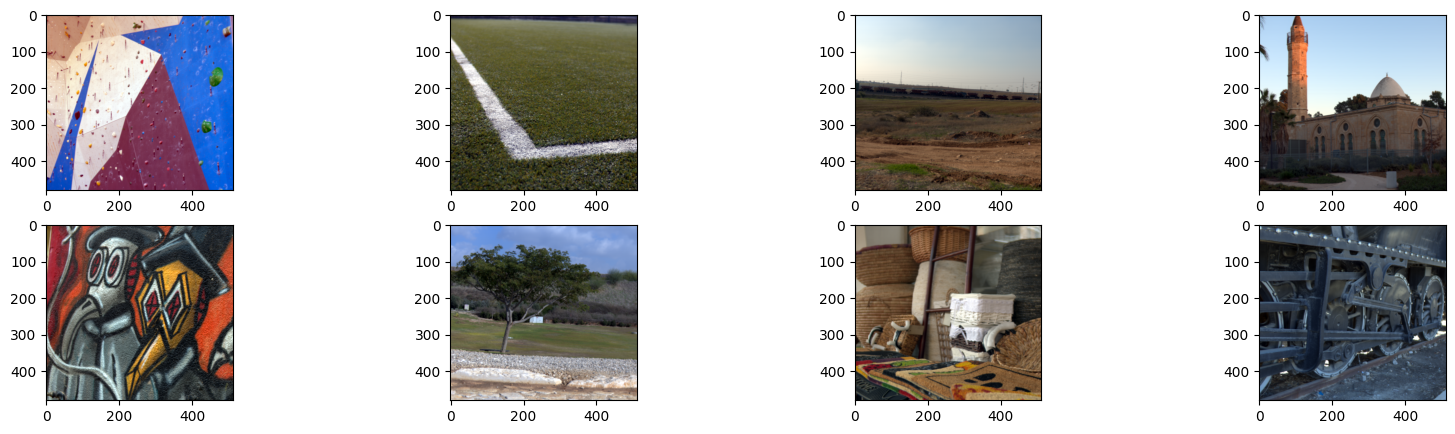

In [ ]:
x, y = train_generator.__getitem__(0)
fig, axis = plt.subplots(2,4, figsize=(20, 5))
k = 0
for ax in axis:
  for a in ax:
    a.imshow(x[k])
    k += 1
    # print(k)
# for i in range(2):
#   for ii in range(4):
#     plt.imshow(x[0], axis = axis[i][ii])      
# print(x.shape)
# print(y.shape)


In [ ]:
# chnage size and shape of the images from KAUST dataset
# k = 1
# for i in os.listdir(KAUST_PATH):
#   f_name = os.path.join(KAUST_PATH, i)
#   print(f_name)
#   process_h5(f_name, k)
#   k += 1

In [ ]:
from tensorflow import keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, LeakyReLU
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate
from keras.models import Model, Sequential
import keras.backend as K
from keras import metrics

In [ ]:
def convolution_operation(entered_input, filters=64):
    conv1 = Conv2D(filters, kernel_size = (3,3), padding = "same")(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    # act1 = ReLU()(batch_norm1)
    act1 = LeakyReLU()(batch_norm1)
    conv2 = Conv2D(filters, kernel_size = (3,3), padding = "same")(act1)
    batch_norm2 = BatchNormalization()(conv2)
    # act2 = ReLU()(batch_norm2)
    act2 = LeakyReLU()(batch_norm2)
    
    return act2

In [ ]:
def encoder(entered_input, filters=64):
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(strides = (2,2), padding='valid')(enc1)
    return enc1, MaxPool1

In [ ]:
def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=2, padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    return out

In [ ]:
def U_Net(Image_Size):
    input1 = Input(Image_Size)
    # input2 = BatchNormalization()(input1)
    #480x512
    skip1, encoder_1 = encoder(input1, 64)
    #480x512 /2 = 240x256
    skip2, encoder_2 = encoder(encoder_1, 64*2)
    #240x256 /2 = 120x128
    skip3, encoder_3 = encoder(encoder_2, 64*4)
    #120x128 /2 = 60x64
    skip4, encoder_4 = encoder(encoder_3, 64*8)
    # #60x64 /2 = 30x32
    # Preparing the next block
    conv_block = convolution_operation(encoder_4, 64*8)
    #30x32
    
    # Construct the decoder blocks
    decoder_1 = decoder(conv_block, skip4, 64*8)
    decoder_2 = decoder(decoder_1, skip3, 64*4)
    decoder_3 = decoder(decoder_2, skip2, 64*2)
    decoder_4 = decoder(decoder_3, skip1, 64)
    
    # pre_out = Conv2DTranspose(31, strides=1, kernel_size = (3,1))(decoder_4)
    out = Conv2D(31, 1, padding="same", activation="sigmoid")(decoder_4)

    model = Model(input1, out)
    return model

In [ ]:
input_shape = (256, 256, 3)
model = U_Net(input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras import backend as K
EPSILON = 1e-10
def MRAE(y_pred, y_true):
  return K.mean(K.abs(y_true - y_pred) / (y_true + EPSILON))

In [ ]:
op = keras.optimizers.Adam(0.01)
model.compile(optimizer=op, loss=tf.keras.losses.MeanSquaredError(), metrics=[MRAE, tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/checkpoint_final/leaky1_{val_loss:.2f}.hdf5'

In [ ]:
EPOCHS = 10
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose = 1,
    save_freq='epoch'
    )

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.001)

In [ ]:
# tf.config.list_physical_devices('GPU')
model.load_weights("/content/gdrive/MyDrive/checkpoint_final/leaky1_0.02.hdf5")
# new_model = keras.models.load_model(checkpoint_filepath)

In [ ]:
# with tf.device('/GPU:0'):
#   model.fit(train_generator, validation_data= val_generator, epochs=EPOCHS, verbose=1, workers = -1, callbacks=[reduce_lr, model_checkpoint_callback])

In [ ]:
# model.save(checkpoint_filepath)

In [ ]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/release/train",
    label_mode="binary",
    batch_size=8,
    image_size=(256, 256)
)
val_gen = tf.keras.utils.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/release/validation",
    label_mode="binary",
    batch_size=8,
    image_size=(256, 256)
)
test_gen = tf.keras.utils.image_dataset_from_directory(
    directory="/content/gdrive/MyDrive/release/test",
    label_mode="binary",
    batch_size=1,
    image_size=(256, 256)
)

Found 5000 files belonging to 2 classes.
Found 540 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
from keras.layers import RandomFlip, RandomRotation, Resizing, Flatten, Dense

In [ ]:
def d_augmentation(entered_input):
  r_flip = RandomFlip()(entered_input)
  r_rotation = RandomRotation(factor = 0.25, fill_mode= "constant", fill_value = 0)(r_flip)
  return r_rotation

In [ ]:
def unet_with_efficient_net(Input_image):
  # model.trainable = True
  input1 = Input(Input_image)
  aug = d_augmentation(input1)
  # resized = Resizing(X_SHAPE, Y_SHAPE, interpolation="bicubic")(aug)
  hyper = model(aug)
  eff = tf.keras.applications.EfficientNetB4(include_top=False, weights=None, input_shape=(256, 256, 31))(hyper)
  flat = Flatten()(eff)
  out = Dense(1, "sigmoid")(flat)
  final_model = Model(input1, out)
  return final_model

In [ ]:
model_final = unet_with_efficient_net((256,256,3))
model_final.summary()

/usr/local/lib/python3.10/dist-packages/keras/applications/efficientnet.py:321: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 31 input channels.
  input_shape = imagenet_utils.obtain_input_shape(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 256, 256, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 256, 256, 3)      0         
 tion)                                                           
                                                                 
 model (Functional)          (None, 256, 256, 31)      20566367  
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17685975  
                                                                 
 flatten (Flatten)           (None, 114688)            0         
                                                           

In [ ]:
op = keras.optimizers.Adam(0.01)
model_final.compile(optimizer=op, loss=tf.keras.losses.BinaryCrossentropy(),  metrics=[keras.metrics.AUC()])

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/checkpoint_final/combined_leaky_train_{val_auc:.2f}.hdf5'
# model_final.load_weights("/content/gdrive/MyDrive/checkpoint_final/combined_leaky_0.69.hdf5")

In [ ]:
EPOCHS = 10
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose = 1,
    save_freq='epoch'
    )

In [ ]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=2, min_lr=0.1e-4)
# model_final.metrics

In [ ]:
with tf.device('/GPU:0'):
  model_final.fit(train_gen, validation_data= val_gen, epochs=EPOCHS, verbose=1, workers = -1, callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/10
 21/625 [>.............................] - ETA: 11:18 - loss: 29.7311 - auc: 0.5133

KeyboardInterrupt: ignored

In [ ]:
model_final.evaluate(test_gen)

In [ ]:
fig, axis = plt.subplots(1,3, figsize=(20, 5))
axis[0].plot([162.7489, 0.658, 0.62, 0.5993, 0.5854, .5878, .5779, .5636, .5426, .5398])
axis[0].set_ylabel("Loss")
axis[0].set_title("ARAD")
axis[0].set_ylim([0, 1])


axis[1].plot([2.0758, 0.5423, 0.5241, 0.5063, 0.4811, .4895, .4688, .4813, .4616, .4891])
# axis[1].set_ylabel("Loss")
axis[1].set_title("KAUST")
axis[1].set_ylim([0, 1])


axis[2].plot([0.5696, 0.5172, 0.5072, 0.5098, 0.5156, .4980, .5165, .5045, .4855, .4774])
# axis[2].set_ylabel("Loss")
axis[2].set_title("Combined")
axis[2].set_ylim([0, 1])

plt.show()